## Imports

In [1]:
import pandas as pd
import numpy as np
import os
import datetime
from matplotlib import pyplot as plt
import seaborn as sns
import json

In [2]:
def moving_average(timeseries, window):
    """Calculate the moving average of a timeseries.

    Args:
        timeseries (pd.Series): timeseries
        window (int): Window size

    Returns:
        pd.Series: Smoothened timeseries
    """
    return timeseries.rolling(window=window, center=True).mean()

## Define peak hours

In [3]:
# Define peak hours 8-11 and 16-19
peak_hours = list(range(8,20))
# All hours
all_hours = list(range(24))
# difference between peak hours and all hours (off_peak_hours)
off_peak_hours = list(set(all_hours) - set(peak_hours))

## Spot prices from the dataset
Load and prepare dataset

In [5]:
fp = "data/gridtx-dump-AGGREGATED-CLEANED-THRESHOLD-COVERAGE100-NORMALIZED.csv"
data = pd.read_csv(fp, sep=",")

# Meter with most observations
mm_id = "e882f9a7-f1de-4419-9869-7339be303281"

df = data[data["meter_id"] == mm_id]

df_cons = df[df["type"] == "consumption"]

df_cons.index = pd.to_datetime(df_cons['timeslot'], utc=True)
df_cons = df_cons.sort_index()


In [6]:
df_2017 = df_cons[df_cons.index.year == 2017]

df_2017["peak"] = np.where(df_2017.index.hour.isin(peak_hours), True, False)

C:\Users\andre\AppData\Local\Temp\ipykernel_23056\2341981275.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2017["peak"] = np.where(df_2017.index.hour.isin(peak_hours), True, False)


In [7]:
# Group by day of year and peak
df_2017_avg = df_2017.groupby([df_2017.index.dayofyear, "peak"]).mean()["spot_price_no_vat"]

In [8]:
# Create dictionary with day of year and hour as key and spot price as value
df_2017_avg_dict = df_2017_avg.to_dict()

hour_lookup_price_dict = {}

# loop though group
for dayofyear in df_2017.index.dayofyear: 
    for hour in all_hours:
        # if hour_lookup_price_dict has key
        if dayofyear not in hour_lookup_price_dict:
            hour_lookup_price_dict[dayofyear] = {}
        hour_lookup_price_dict[dayofyear][hour] = df_2017_avg_dict[(dayofyear, hour in peak_hours)]
        

In [9]:
# save hour_lookup_price_dict to json
with open('data/hour_lookup_price_dict.json', 'w') as fp:
    json.dump(hour_lookup_price_dict, fp)

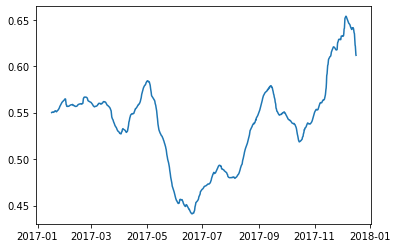

In [10]:
# plot hour_lookup_price_dict
plt.plot(moving_average(df_2017["spot_price_no_vat"],24*31))
plt.show()

## Spot prices from Nordpool (2021)
Load and prepare data


In [11]:
# Load csv
nordpool_df = pd.read_csv("data/nordpool_dump_2022-06-13.csv", sep=",")

# Only get data for Oslo 
nordpool_df = nordpool_df[nordpool_df["Name"] == "Oslo"]
# Convert from MWh to kWh
nordpool_df["parsed_values"] = nordpool_df["parsed_values"]/1000
# drop all columns except parsed_values and timestamp
nordpool_df = nordpool_df[["parsed_values", "timestamp"]]
nordpool_df.index = pd.to_datetime(nordpool_df['timestamp'], utc=True)

# nordpool_df missing values
print("There are", nordpool_df["parsed_values"].isnull().sum(), "missing values in parsed_values")

There are 1 missing values in parsed_values


In [12]:
# interpolate missing values
nordpool_df["parsed_values"] = nordpool_df["parsed_values"].interpolate()

In [13]:
# Add peak column (boolean) and average over on peak/off peak each day
nordpool_df["peak"] = np.where(nordpool_df.index.hour.isin(peak_hours), True, False)
nordpool_df_avg = nordpool_df.groupby([nordpool_df.index.dayofyear, "peak"]).mean()["parsed_values"]

In [14]:
nordpool_df_avg_dict = nordpool_df_avg.to_dict()
# Create dictionary with day of year and hour as key and spot price as value
nordpool_df_avg_dict = nordpool_df_avg.to_dict()

nordpool_hour_lookup_price_dict = {}

# loop though group
for dayofyear in nordpool_df.index.dayofyear: 
    for hour in all_hours:
        # if hour_lookup_price_dict has key
        if dayofyear not in nordpool_hour_lookup_price_dict:
            nordpool_hour_lookup_price_dict[dayofyear] = {}
        nordpool_hour_lookup_price_dict[dayofyear][hour] = nordpool_df_avg_dict[(dayofyear, hour in peak_hours)]
        

In [15]:
# save hour_lookup_price_dict to json
with open('data/nordpool_hour_lookup_price_dict.json', 'w') as fp:
    json.dump(nordpool_hour_lookup_price_dict, fp)

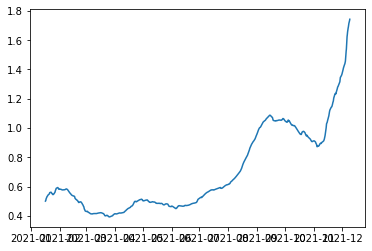

In [16]:
# plot hour_lookup_price_dict
plt.clf()
plt.plot(moving_average(nordpool_df["parsed_values"],24*31))
plt.show()

Plot both prices (smoothened)

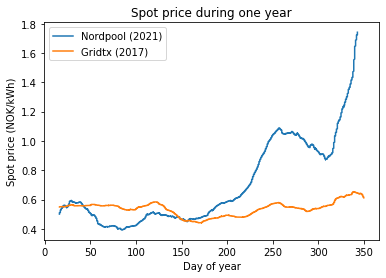

In [31]:
# Plot nordpool_df together with df_2017 with same x-axis
plt.clf()
plt.plot(nordpool_df.index.dayofyear,moving_average(nordpool_df["parsed_values"], 24*31), label="Nordpool (2021)")
plt.plot(df_2017.index.dayofyear,moving_average(df_2017["spot_price_no_vat"], 24*31), label="Gridtx (2017)")
# x-axis
plt.xlabel("Day of year")
# y-axis
plt.ylabel("Spot price (NOK/kWh)")
# title
plt.title("Spot price during one year")
plt.legend()
plt.show()


Plot both (not smoothened)

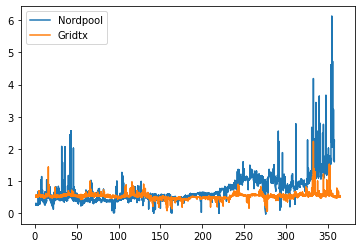

In [18]:
# Plot nordpool_df together with df_2017 with same x-axis
plt.clf()
plt.plot(nordpool_df.index.dayofyear,nordpool_df["parsed_values"], label="Nordpool")
plt.plot(df_2017.index.dayofyear,df_2017["spot_price_no_vat"], label="Gridtx")
plt.legend()
plt.show()


## Analyze prices
Descriptive statistics

In [27]:
desc1 = nordpool_df["parsed_values"].describe()
desc2 = df_cons["spot_price_no_vat"].describe()

# Merge desc1 and desc2
desc = pd.concat([desc1, desc2], axis=1)
desc.columns = ["Nordpool", "gridtx"]
desc

,Nordpool,gridtx
count,8592.000000,21863.00000
mean,0.740616,0.71475
std,0.469412,0.21774
min,-0.019720,0.03636
25%,0.457335,0.54400
50%,0.595440,0.67400
75%,0.930945,0.86141
max,6.124930,4.90800
